# Algoritmo di Shor

## Introduzione

L'algoritmo di Shor è un algoritmo quantistico sviluppato dal matematico Peter Shor nel 1994, famoso per la sua capacità di scomporre rapidamente numeri interi in fattori primi. A differenza degli algoritmi classici, che richiedono un tempo esponenziale per eseguire questa operazione, l'algoritmo di Shor sfrutta le proprietà della meccanica quantistica per ridurre drasticamente il tempo di calcolo, rendendo possibile la fattorizzazione in tempo polinomiale. Questo lo rende particolarmente rilevante per la crittografia moderna, poiché potrebbe compromettere la sicurezza di sistemi come RSA, che si basano proprio sulla difficoltà della fattorizzazione.

### Versione delle librerie Qiskit usate

In [1]:
# Print qiskit library version
import qiskit
import qiskit_aer
import qiskit_ibm_runtime

print(f"Qiskit Version: {qiskit.__version__}")
print(f"Qiskit-aer Version: {qiskit_aer.__version__}")
print(f"Qiskit-ibm-runtime Version: {qiskit_ibm_runtime.__version__}")


Qiskit Version: 1.3.2
Qiskit-aer Version: 0.16.0
Qiskit-ibm-runtime Version: 0.34.0


### Librerie necessarie per l'esecuzione dell'algoritmo

In [2]:
#Import all the needed library

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.circuit.library import QFT, UnitaryGate, IntegerComparator
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

import numpy as np
from math import gcd, log2, ceil
from random import randint
from fractions import Fraction


### Set-Up del Token per l'esecuzione sui computer di IBM

In [3]:
# Load the ibm token if needed

def setup_token():
    print("Loading Token")
    file = open("token_loaded.txt", "r")
    token_loaded = file.read()
    file.close()
    if not token_loaded == 'True':
        print("Not Loaded")
        file = open("token.txt", "r")
        ibm_token = file.read()
        file.close()
        print("Read Token from file")
        QiskitRuntimeService.save_account( ibm_token, channel = 'ibm_quantum', overwrite=True )
        file = open("token_loaded.txt", "w")
        file.write("True")
        file.close()
        print("Loaded")
    print("Done")

setup_token()


Loading Token
Done


### Fattorizzazione usando il periodo

Nell'algoritmo di Shor usiamo la computazione per deteterminare il periodo $r$ della funzione di congruenza $N$.
Dato un numero $a$ che è coprimo con $N$, l'ordine $r$ di $a$ è il numero intero più piccolo che renda vera la congruenza:

$$ a^r \equiv 1 \pmod{N} $$

Una volta che conoscimao $r$ possiamo determinare i fattori di $N$ usando questi ragionamenti:

Se $r$ è pari possimao scrivere:

$$ a^r - 1 = (a^{r/2} - 1)(a^{r/2} + 1) \equiv 0 \pmod{N} $$

Di consegunga $N$ deve dividere il prodotto:

$$ (a^{r/2} - 1)(a^{r/2} + 1) $$

Siccome $N$ è un numero composto:

$$MCD(a^{r/2} - 1, N) = F1, MCD(a^{r/2} + 1, N) = F2$$

Con $F1$ e $F2$ i fattori non banali di $N$.

In [4]:
# shor number theory

def period_to_factor(N:int, a:int , r:int ):
    """
    Function to convert period into factor.
    Args:
        N (int): Number that needs to be factorized.
        a (int): Number coprime with N of witch we know the order.
        r (int): Order of the number a.
    Returns:
        Tuple(int , int): The 2 factor making-up the number N
    """

    if r % 2 == 0 and pow(a, r // 2, N) not in [-1 % N, 1]:
        p = gcd(pow(a, r // 2, N) + 1, N)
        q = gcd(pow(a, r // 2, N) - 1, N)
        return p, q
    else:
        raise Exception("Not a valid period")


### Funzionde per determinare $a$

Come visto in precedenza abbimo il valore che vogliamo fattorizzare $N$, il quale necessita di due valori $a$ e $r$, in particolre il valore di $a$ è un umero intero scelto a caso nell'intervallo:
$$2\leq a<N$$
coprimo con $N$:
$$MCD(a, N) = d \quad con \quad d=1$$
Nel caso $d$ fosse diverso da $1$, $d$ sarebbe uno dei fattori di $N$ con l'atro fattore uguale a $N/d$, 

In [5]:
# find a (coprime number for N)

def find_a(N: int) -> int | tuple[int, int]:
    """
    Function to find a coprime number with N.
    Args:
        N (int): Number on which the coprime number will be calculated.
    Returns:
        int: The coprime number with N.
    """

    a = randint(2, N - 1)  # Random integer in [2, N-1]
    d = gcd(a, N)
    if d == 1:
        return a  # Valid a found
    else:
        return (d, N // d)  # Not a valid a, return factors of N


In [6]:
N = 21  # Example modulus

while True:
    a = find_a(N)
    if isinstance(a, int):
        break
    else:
        print(f"Found factors of N: {a}")

print(f"Running QPE for N={N}, a={a}")


Found factors of N: (3, 7)
Found factors of N: (3, 7)
Running QPE for N=21, a=19


### Determinazione del periodo $r$

Il calcolo del periodo è divso in due parti:
- Calcolo della fase tramite QPE (Quantum Phase Estimation)
- Metode delle Frazioni continue per calcolare il periodo dalla fase

#### Quantum Phase Estimation

Sapendo che $U$ è una operazione unitaria decrivibile con una matrice reversibine (ovvero $UU\dagger = I$) :

$$U^x|\psi \rangle =e^{2\pi i xk/r }|\psi \rangle$$

L'algoritmo ci va a calcolare $ s = 2^{n}\phi$ con $n$ indica il numero di qubit utilizzati per il conteggio e la phase $\phi$ con $\phi = k/r$ di un operazione unitaria $U$ i cui autovalori siano legati a $r$ 

$$ U|x\rangle = |a * x \pmod{N} \rangle$$

Sapendo inoltre dalla aritmetica modulare che:

$$ a * x \pmod{N} = (a\pmod{N} * x\pmod{N} )\pmod{N}$$

e che nella QPE vado ad utilizzare anche $ U^{2^j}$ possimo scrivere per ogni matrice $ U_j$:

$$ U_j|x\rangle = |b_j * x \pmod{N} \rangle \qquad dove \qquad b_j = a^{2^j} \pmod{N} $$

Come primo passaggio dell'algoritmo vado a mettere in superposition il registro di conteggio $|0⟩^{⊗n}$ applicando le porte di hadamard:

$$ |0\rangle \to \dfrac{1}{\sqrt{2^n}} \sum_{s=0}^{2^n -1 } |s\rangle$$

e otteniamo come stato iniziale:

$$ \dfrac{1}{\sqrt{2^n}} \sum_{s=0}^{2^n -1 } |s\rangle ⊗ |\psi \rangle$$

a questo punto andiamo ad applicare le controlled $U_j$. Ogni qubit di controllo raccoglie una "phase kickback" così facenodo andiamo ad ottenere:

$$ \dfrac{1}{\sqrt{2^n}} \sum_{s=0}^{2^n -1 } |s\rangle e^{2\pi i sk/r }|\psi \rangle$$

a questo punto nel registro di counting abbimao la fase codificata come:

$$\dfrac{1}{\sqrt{2^n}} \sum_{s=0}^{2^n -1 } e^{2\pi i sk/r } |s\rangle $$

e trami la $QFT\dagger$ il valore conllassa in un valore $s$:

$$ \dfrac{s}{2^n} \approx \dfrac{k}{r}$$







In [7]:
# phase estimator

def construct_U_gate(a_power, N):
    """
    Constructs the unitary gate for the operation U: |x> → |(a^power * x) mod N>.
    For x >= N, U leaves |x> unchanged.
    """
    m = ceil(log2(N))
    size = 2 ** m
    matrix = np.eye(size, dtype=complex)
    for x in range(N):
        y = (a_power * x) % N
        matrix[:, [x, y]] = matrix[:, [y, x]]
    return UnitaryGate(matrix, label=f"U^{a_power}")

def quantum_phase_estimation(N, a, n_counting=None):
    """
    Constructs the Quantum Phase Estimation circuit for the unitary U: |x> → |a*x mod N>.
    Args:
        N (int): The modulus.
        a (int): The multiplier, coprime with N.
        n_counting (int, optional): Number of counting qubits. Defaults to 2*ceil(log2(N)).
    Returns:
        QuantumCircuit: The QPE circuit.
    """
    # Validate inputs
    if gcd(a, N) != 1:
        raise ValueError(f"{a} and {N} must be coprime.")

    m = ceil(log2(N))
    if n_counting is None:
        n_counting = 2 * m  # Increased precision

    # Quantum registers
    qr_counting = QuantumRegister(n_counting, 'counting')
    qr_eigen = QuantumRegister(m, 'eigen')
    cr_measure = ClassicalRegister(n_counting, 'measure')
    qc = QuantumCircuit(qr_counting, qr_eigen, cr_measure)

    # Initialize eigenstate to |1>
    qc.x(qr_eigen[0])

    # Apply Hadamard gates to counting qubits
    qc.h(qr_counting)

    # Apply controlled-U^(2^i) operations
    for i in range(n_counting):
        a_power = pow(a, 2**i, N)
        U_i = construct_U_gate(a_power, N)
        cU_i = U_i.control(1)
        qc.append(cU_i, [qr_counting[i]] + qr_eigen[:])

    # Apply inverse Quantum Fourier Transform
    qft_dagger = QFT(num_qubits=n_counting, inverse=True, insert_barriers=True)
    qc.append(qft_dagger, qr_counting)

    # Measure only the counting qubits
    qc.measure(qr_counting, cr_measure)

    return qc


#### Metodo delle frazioni continue

A questo punto dopo che abbimo raccolto tutti i risulatati dalle esecuzioni prensiamo il risulato più frequente e lo trasformiamo nella nostra fase $\phi$

$$ \phi = s / 2^n$$

e tramite l'algoritmo delle frazioni continue andiamo a trovare la miglior frazione che approssima il valore della fase e andiamo a recuperare il valore al denominator che rappresenta la nostra $r$

In [8]:
# from phase to period

def post_process_qpe_results(counts, N, a):
    """
    Post-processes the QPE measurement results to determine the order r.
    Args:
        counts (dict): Measurement results from the QPE circuit.
        N (int): The modulus.
        a (int): The multiplier, coprime with N.
    Returns:
        int: The order r of a modulo N.
    """

    # Find the most frequent measurement result
    most_frequent_result = max(counts, key=counts.get)

    # Convert the binary result to an integer s
    s = int(most_frequent_result, 2)

    # Get number of counting qbits
    n_counting = len(most_frequent_result)

    # Approximate the phase phi = s / 2^n
    phi = s / (2 ** n_counting)

    # Use the continued fractions algorithm to approximate phi as k/r
    fraction = Fraction(phi).limit_denominator(N)
    k, r = fraction.numerator, fraction.denominator

    # Verify if r is the order of a modulo N
    if pow(a, r, N) == 1 and r % 2 == 0 and pow(a, r // 2, N) not in [-1 % N, 1]:
        return r
    else:
        # If r is not the order, try multiples of r
        for multiple in range(2, N):
            candidate_r = r * multiple
            if pow(a, candidate_r, N) == 1:
                return candidate_r
    raise ValueError(f"Can't find r = {r}")

In [9]:
def simulate_qpe(qc, shots=1024):
    """
    Simulates the QPE circuit and returns the measurement results.
    Args:
        qc: Quantum circuit to simulate.
    Returns:
        dict: Measurement counts.
    """
    simulator = AerSimulator()  # Correct backend for Qiskit Aer 0.16.0
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=shots).result()
    return result.get_counts()


Generated QPE circuit


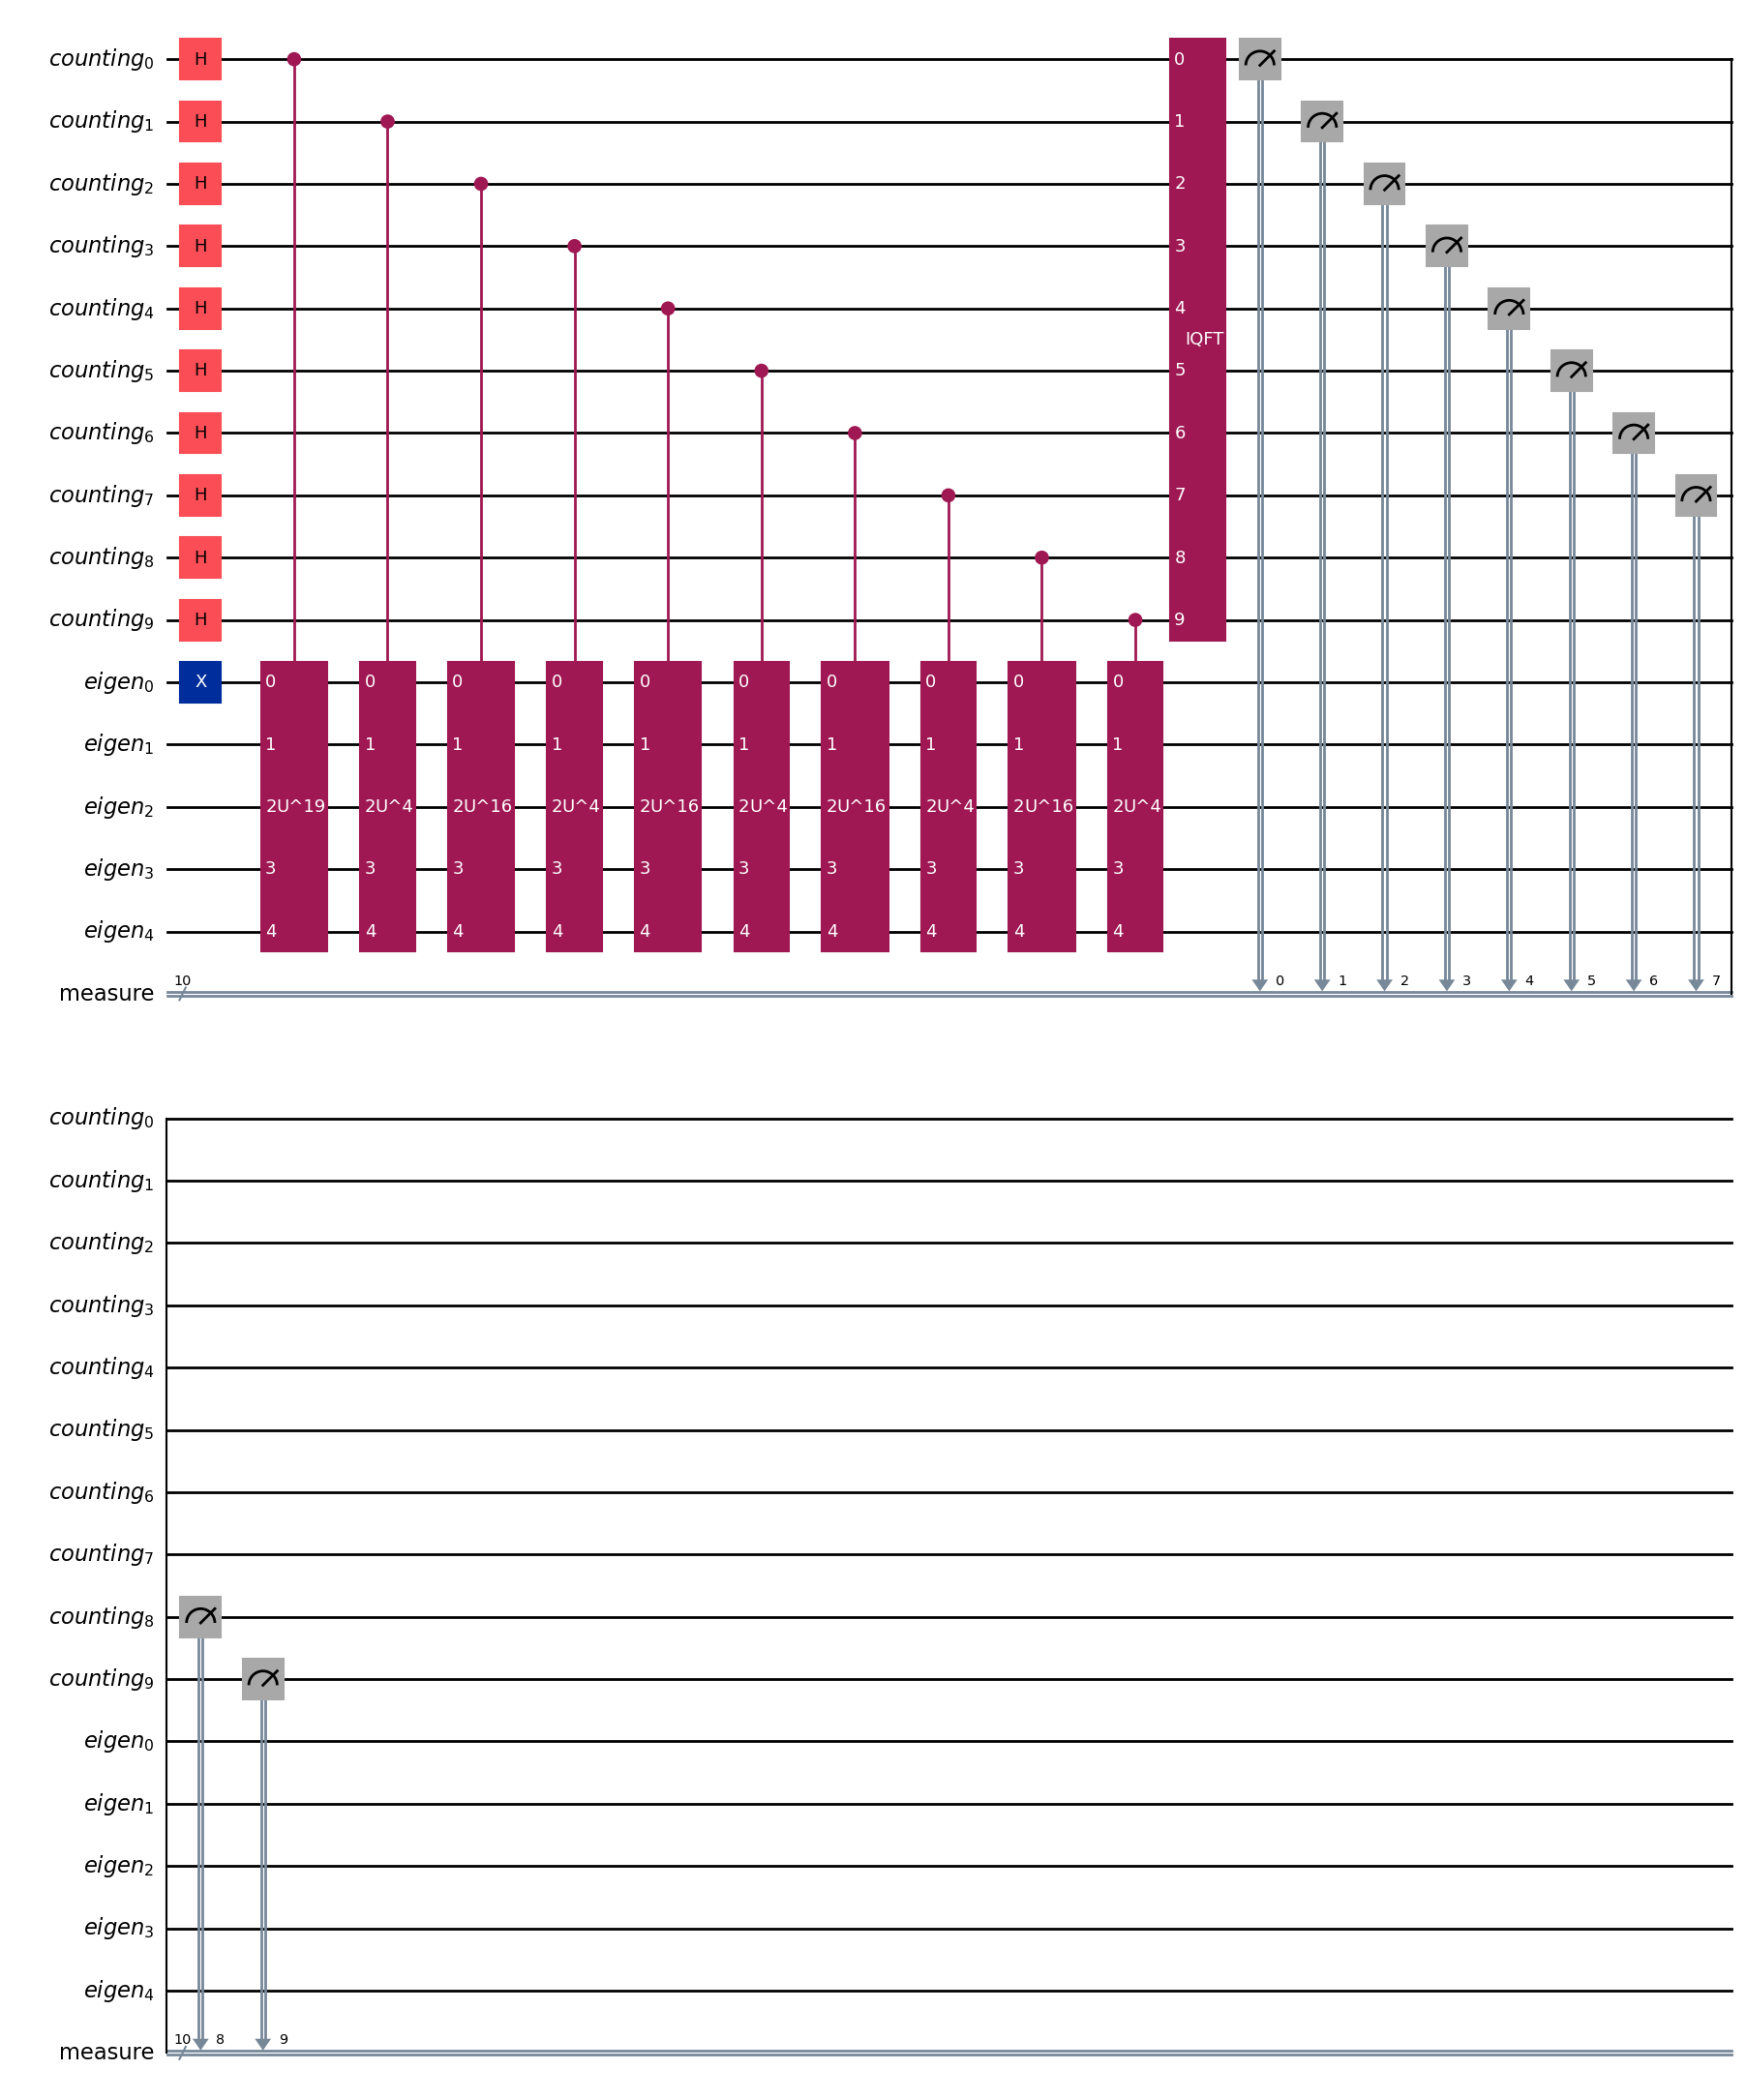

In [10]:
qc_out = quantum_phase_estimation(N, a)
print("Generated QPE circuit")
qc_out.draw(output = 'mpl')


In [11]:

try:
    counts = simulate_qpe(qc_out)
    print("Measurement results:", counts)

    r = post_process_qpe_results(counts, N, a)
    print("Period:", r)

    result = period_to_factor(N, a, r)
    print(f"Result: {result}")
except:
    print("The Simulator was not able to determine the period")



Measurement results: {'1000110101': 1, '0101000111': 4, '1000000000': 174, '1101000111': 1, '1011000111': 2, '0000000000': 171, '0010101001': 2, '1001100011': 4, '1110100011': 3, '0110010101': 2, '1101100110': 2, '0101011001': 1, '0010110111': 1, '1110000110': 2, '1110011001': 4, '0110011101': 5, '0101101110': 3, '0101111110': 2, '1101000011': 1, '1011000011': 2, '0110100110': 7, '1110001011': 3, '0101110010': 3, '0001010011': 1, '1001000110': 2, '1111000110': 3, '1110011101': 4, '0001110011': 4, '0100011101': 1, '1110010010': 7, '1011001011': 1, '1101001011': 2, '1111010010': 1, '1000110010': 1, '1110011010': 3, '0001110110': 1, '0100010111': 1, '1101011010': 2, '1011000110': 3, '1010111010': 3, '1101000110': 4, '0111001101': 1, '1111101101': 2, '1011100001': 1, '1000110110': 1, '1001011101': 2, '1110111101': 1, '0101001101': 1, '1101110011': 3, '1010110011': 1, '1101001101': 2, '1011001101': 2, '1101010011': 3, '0010010010': 1, '0010001100': 3, '0010111010': 1, '0101110101': 1, '1010

In [12]:
#select quantum backend

service = QiskitRuntimeService()
backend = service.least_busy()

print(f'Selected backend: {backend.name} with {backend.status().pending_jobs} pending jobs')

Selected backend: ibm_brisbane with 12 pending jobs


In [13]:
# transpile for the circuit for the selected backend

transpiled_qc = transpile(
    qc_out,
    backend=backend,  # Use the backend for transpilation
    optimization_level=2 # Medium-High optimization level
)

print("Transpiled")


Transpiled


In [14]:
# run the circuit

sampler = Sampler(backend)
job = sampler.run([transpiled_qc], shots=1024)

print("Job ID:", job.job_id)
print("Job status:", job.status())


Job ID: <bound method BasePrimitiveJob.job_id of <RuntimeJobV2('cz31wgj39f40008s4t60', 'sampler')>>
Job status: QUEUED


In [15]:
# Get the result from execution on quantum computer

pub_result = job.result()[0]
quasi_dists = pub_result.data.measure.get_counts()  # Use 'meas' for measurement results

# Print the quasi-distribution
print("Quasi-probability distribution:", quasi_dists)


Quasi-probability distribution: {'0101000101': 1, '1110111101': 2, '0111011110': 2, '1100011000': 4, '0111001110': 2, '0000010010': 2, '1010111110': 1, '0000101011': 1, '1001101110': 2, '0000001001': 2, '0111001001': 2, '1000001100': 3, '1101110111': 5, '1000101100': 1, '1000011001': 1, '0011111000': 2, '0111110011': 1, '0111100010': 2, '0001110110': 2, '0010101000': 2, '1010011011': 2, '0010011100': 1, '0010111011': 1, '1000000100': 2, '0110000001': 1, '1110110001': 1, '0010001000': 1, '1011110001': 1, '0100101011': 1, '1100111000': 1, '1010001100': 2, '0101100101': 1, '0001011010': 2, '1011011011': 2, '1101000110': 1, '0110010101': 1, '1010000001': 1, '0010011010': 2, '0011000010': 2, '0000100001': 1, '0010001111': 2, '1011101110': 1, '0101000001': 2, '0110001011': 1, '0000110001': 3, '1000011011': 1, '1101010100': 1, '0101110010': 1, '1111100001': 2, '0011010001': 1, '1100111110': 2, '1010101101': 2, '1110001101': 2, '1101100100': 1, '0110100001': 2, '0111000000': 2, '1101001011': 1

In [16]:
r = post_process_qpe_results(quasi_dists, N, a)
print("Period:", r)

factors = period_to_factor(N, a, r)
print(f"Result: {factors}")

Period: 30
Result: (7, 3)


### Alternative alla U come matrice

Ci sono alcuni modi per rappresentare la nostra $U$ in precedenza abbimao usato una matrice che va bene per numeri piccoli ma se andiamo a prendere dei numeri più grossi la complessità nel calcolare la matrice rende impossibile l'applicazione dell'algoritmo.

Un altra suluzione è quella di andare ad implementare l'esponenzializazione modulare direttamente nel ciruito per semplicità andiamo a supporre che che come valore di $a$ andiamo sempre a prendere $2$ così da rendere facile l'implementazione del prodotto facendo un semplice qubit shift tramite delle swap.

A questo punto per la riduzione modulare dobbimo prima verificare che dobbiamo sottrarre salvando in un qubit flag il risultato ($x \geq N$) e poi eseguire la sottrazzione tramite il qubit flag.

Problema di questa implementazione che per ogni operazione di "modular doublig" rimane sempre un qbit "sporco" che non sarà utilizzabile per le successive operazioni.


In [17]:

def qft_subtractor(num_qubits: int, N: int) -> QuantumCircuit:
    """
    Implements the inverse QFT for subtraction.
    |x⟩ → |x - N⟩
    """

    qr_x = QuantumRegister(num_qubits, 'x')
    qc = QuantumCircuit(qr_x, name='QFTSub')
    
    # Apply QFT
    qc.append(QFT(num_qubits, do_swaps=False).to_gate(), qr_x[:])
    
    # Apply phase rotations for subtraction
    for i in range(num_qubits):
        for j in range(i + 1):
            if (N >> j) & 1:  # if jth bit of N is 1
                # Calculate phase for position
                phase = (2 * np.pi * (2 ** (j)) / (2 ** (num_qubits))) * (2 ** (num_qubits - 1 - i))
                phase = phase % (2 * np.pi)
                if phase != 0:
                    # Note: We use negative phases for subtraction
                    qc.p(-phase, qr_x[i])

    # Apply inverse QFT
    qc.append(QFT(num_qubits, do_swaps=False, inverse=True).to_gate(), qr_x[:])
    
    return qc

def quantum_doubler(num_qubits: int) -> QuantumCircuit:
    """
    Creates a circuit that doubles the input value using QFT
    |x⟩ → |2x⟩
    
    Args:
        num_qubits: Number of qubits in register
    
    Returns:
        QuantumCircuit: Circuit implementing doubling operation
    """
    qr_x = QuantumRegister(num_qubits + 1, 'x')

    qc = QuantumCircuit(qr_x, name='QFTDouble')
    
    # Copy the state |x> into |2x>
    for i in range(num_qubits, 0, -1):
        qc.swap(qr_x[i], qr_x[i - 1])
    
    return qc


def modular_doubler(num_state_qubits, N) -> QuantumCircuit:
    """
    Implements |x⟩ → |(2x) mod N⟩ using bit shifts and modular reduction.
    """

    qr_x = QuantumRegister(num_state_qubits, 'x') # State qubits + 1 for ancilla
    qr_double_ancilla = QuantumRegister(1, 'double_ancilla')
    qr_comp_ancilla = QuantumRegister(num_state_qubits, 'comp_ancilla')
    qr_controller = QuantumRegister(1, 'controller')
    qc = QuantumCircuit(qr_x, qr_double_ancilla, qr_comp_ancilla, qr_controller, name='ModDbl')
    
    # Double the input
    qc.append(quantum_doubler(num_state_qubits).to_gate(), qr_x[:] + qr_double_ancilla[:])
    
    # Modular reduction: If result >= N, subtract N
    grater_cmp = IntegerComparator(num_state_qubits + 1, N, geq=True).to_gate()
    qc.append(grater_cmp, qr_x[:] + qr_double_ancilla[:] + [qr_controller[:]] + qr_comp_ancilla[:])

    # If result >= N, subtract N
    qft_sub = qft_subtractor(num_state_qubits + 1, N).to_gate().control(1)
    qc.append(qft_sub, [qr_comp_ancilla[0]] + qr_x[:] + qr_double_ancilla[:])
    
    return qc



In [18]:
def mod_exp_a_2(num_qubits: int, a_power: int, N: int, same_comp_qreg: bool) -> QuantumCircuit:
    """
    Implements |x⟩ → |2^(2^power) * x mod N⟩ using controlled modular doubling.
    """

    qr = QuantumRegister(2 * num_qubits + 1, 'qr')
    if not same_comp_qreg:
        qr_resetter = QuantumRegister(a_power, 'ancilla_comp')
    else:
        qr_resetter = QuantumRegister(1, 'ancilla_comp')
    qc = QuantumCircuit(qr, qr_resetter, name='ModExp')

    # Apply controlled modular doubling
    mod_dbl = modular_doubler(num_qubits, N).to_gate()
    if not same_comp_qreg:
        for i in range(a_power):
            qc.append(mod_dbl, qr[:(num_qubits + 1)] + [qr_resetter[i]] + qr[(num_qubits + 1):])
    else:
        for _ in range(a_power):
            qc.append(mod_dbl, qr[:(num_qubits + 1)] + [qr_resetter[0]] + qr[(num_qubits + 1):])

    return qc

def phase_estimation_a_2(N: int = 15, same_comp_qreg: bool = False) -> QuantumCircuit:
    """
    Performs phase estimation for controlled modular exponentiation.
    """
    m = ceil(log2(N))

    n_counting = 2 * m  # Increased precision

    if not same_comp_qreg:
        num_ancilla_comp = (2 ** n_counting) - 1 
    else:
        num_ancilla_comp = 1

    # Quantum registers
    qr_counting = QuantumRegister(n_counting, 'counting')
    qr_eigen = QuantumRegister(m, 'eigen')
    qr_ancilla = QuantumRegister(m + 1, 'ancilla')
    qr_reset_comparator = QuantumRegister(num_ancilla_comp, 'reset_comparator')
    cr_measure = ClassicalRegister(n_counting, 'measure')
    qc = QuantumCircuit(qr_counting, qr_eigen, qr_ancilla, qr_reset_comparator, cr_measure)

    # Initialize eigenstate to |1>
    qc.x(qr_eigen[0])

    # Apply Hadamard gates to counting qubits
    qc.h(qr_counting[:])

    # Apply controlled-U^(2^i) operations
    # Controlled modular doubling operations
    used_ancilla_comp = 0
    for i in range(n_counting):
        a_power: int = 2 ** i 
        power_mod_mul = mod_exp_a_2(m, a_power, N, same_comp_qreg)
        if not same_comp_qreg:
            qc.append(power_mod_mul.to_gate().control(1), [qr_counting[i]] + qr_eigen[:] + qr_ancilla[:] + qr_reset_comparator[used_ancilla_comp:used_ancilla_comp + a_power])
        else:
            qc.append(power_mod_mul.to_gate().control(1), [qr_counting[i]] + qr_eigen[:] + qr_ancilla[:] + qr_reset_comparator[:])
        used_ancilla_comp += a_power

    # Apply inverse Quantum Fourier Transform
    qft_dagger = QFT(num_qubits=n_counting, inverse=True, insert_barriers=True)
    qc.append(qft_dagger, qr_counting)

    # Measure only the counting qubits
    qc.measure(qr_counting, cr_measure)
    
    return qc

In [19]:
qc = phase_estimation_a_2(15)
qc.draw(output = 'mpl')

### Considerazioni

Questa implementazione richiede $(2 ^{2 * ceil(log2(N))}) - 1 $ qubit solo per tutte le operazioni di comparazione rendendo anche sta volta impossiblile l'applicaziuone dell'algoritmo per numeri "grandi" (già con 15 non sono in grado di eseguire l'algoritmo sul computer quantitstico che ho a disposizione per mancanza di qubit), fino a che non ci saranno computer quantistici con abbastaza qubit per qualsiasi $N$ che si intenda fattorizzare o finchè non si sarà in grado di reinizializzare o resettare un qubit durante l'esecuzione del circuito.

### Just for fun

Utilizzando sempre la verione precedente dell'algoritmo con una piccola variazione (riutilizzo anche il qubit di flag anche se sporco) vediamo se siamo fortunati e troviamo i valori interessati comunque.

In [20]:
def do_everything_only_simulation(numero: int):
    try:
        qc = phase_estimation_a_2(numero, True)
        print("Generated QPE circuit")

        counts = simulate_qpe(qc)
        print("Measurement results:", counts)

        r = post_process_qpe_results(counts, numero, 2)
        print("Period:", r)

        result = period_to_factor(numero, 2, r)
        print(f"Result: {result}")

    except:
        print(f"The Simulator failed for number {numero}")

In [21]:
do_everything_only_simulation(15)

Generated QPE circuit
Measurement results: {'00100111': 1, '10010110': 2, '01010000': 1, '10011001': 28, '00011010': 62, '01100100': 3, '01001101': 73, '10110010': 1, '10000000': 103, '00011000': 3, '10110011': 87, '10011011': 3, '11001101': 92, '11100110': 74, '00110100': 6, '00011100': 2, '01100110': 56, '00011001': 27, '01100101': 4, '01101101': 1, '11100101': 3, '10011010': 62, '00000000': 101, '11100111': 25, '11001110': 2, '00110101': 2, '10011100': 2, '11001100': 5, '00110011': 88, '11100000': 2, '00110010': 3, '10001001': 1, '01100111': 25, '00011011': 4, '10011000': 6, '10110110': 2, '01011100': 1, '11110001': 1, '01101010': 1, '11001111': 2, '11100100': 1, '01001111': 1, '01100001': 1, '11010111': 1, '00011111': 1, '01100011': 2, '11100011': 1, '00110001': 1, '11110000': 3, '01101000': 2, '10110100': 5, '01001110': 3, '01101001': 2, '01001100': 5, '10100011': 1, '11110011': 1, '01010110': 1, '01010011': 1, '10110001': 1, '11110111': 1, '10010111': 1, '11101000': 5, '00100100'